# Isiah Montalvo Evil Geniuses Data Analyst Internship Assessment

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
df = pd.read_excel("data/social_data.xlsx")

## Data Cleaning

In [3]:
df.dtypes

Published Date       datetime64[ns]
Account                      object
Account Type                 object
Campaign Name                object
Total Impressions             int64
Total Engagements             int64
Media Type                   object
dtype: object

In [4]:
df.columns = [column.replace(" ", "_") for column in df.columns]

In [5]:
columns = ["Account", "Account_Type", "Campaign_Name", "Media_Type"]
for column in columns:
    df[column] = df[column].str.strip().str.replace(" ", "_")
    print("Unique {} values: {}".format(column, df[column].unique()))

Unique Account values: ['CSGO' 'General' 'DOTA2' 'Content_Creators' 'Valorant']
Unique Account_Type values: ['TWITTER' 'FBPAGE' 'INSTAGRAM' 'TIKTOK_BUSINESS' 'YOUTUBE'
 'LINKEDIN_COMPANY']
Unique Campaign_Name values: ['N/A' 'Community_Engagement' 'Evergreen' 'Evil_Exhibited']
Unique Media_Type values: ['Text' 'Video' 'Photo' 'Link' 'Carousel' 'Mixed' 'Album']


In [6]:
df.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video


# Tasks: 

## 1) What is the typical engagement rate we can expect? What's the likelihood that we can achieve a 15% engagement rate?

In [7]:
def engagementRate(engagements, impressions):
    return (engagements / impressions) * 100

def averageEngagementRate(engagementRates):
    return np.mean(engagementRates)

In [8]:
badIndexes = df.query("Total_Impressions == 0").index
df = df.drop(badIndexes)
df.query("Total_Impressions == 0").size

0

In [9]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print(typicalEngagementRate)

40.49262176120076


In [10]:
if any(er > 100 for er in engagementRates):
    print("Investigate")
else:
    print("All good")

Investigate


In [11]:
df.query("Total_Engagements > Total_Impressions")

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type
837,2023-03-10 12:37:06,General,FBPAGE,N/A,1,940,Photo
3216,2023-01-19 06:02:34,General,FBPAGE,N/A,5,44,Photo
3457,2023-01-05 11:55:44,General,FBPAGE,N/A,300,3776,Photo


In [12]:
badIndexes = df.query("Total_Engagements > Total_Impressions").index
df = df.drop(badIndexes)
df.query("Total_Engagements > Total_Impressions").size

0

In [13]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print(typicalEngagementRate)

5.3472378661118025


In [14]:
df["Engagement_Rates"] = engagementRates
df.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type,Engagement_Rates
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video,12.766628
6,2023-03-31 19:40:57.383,CSGO,TWITTER,Community_Engagement,1882,83,Photo,4.410202
7,2023-03-31 19:23:57.349,CSGO,TWITTER,Community_Engagement,17892,3076,Video,17.192041
9,2023-03-31 18:55:51.855,CSGO,TWITTER,Community_Engagement,13874,1447,Video,10.429581
10,2023-03-31 18:36:01.000,General,FBPAGE,Community_Engagement,37692,8044,Photo,21.341399


(array([1627.,  609.,  188.,  111.,   69.,   41.,   37.,   22.,    5.,
           7.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

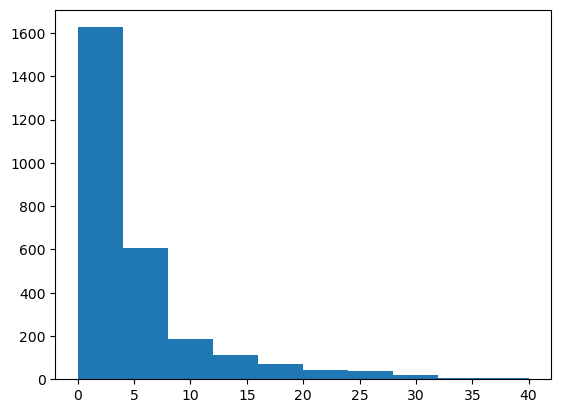

In [15]:
plt.hist(df.Engagement_Rates, range=[0, 40])

In [16]:
badIndexes = df.query("Engagement_Rates == 0").index
probDF = df.drop(badIndexes)
probDF.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type,Engagement_Rates
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video,12.766628
6,2023-03-31 19:40:57.383,CSGO,TWITTER,Community_Engagement,1882,83,Photo,4.410202
7,2023-03-31 19:23:57.349,CSGO,TWITTER,Community_Engagement,17892,3076,Video,17.192041
9,2023-03-31 18:55:51.855,CSGO,TWITTER,Community_Engagement,13874,1447,Video,10.429581
10,2023-03-31 18:36:01.000,General,FBPAGE,Community_Engagement,37692,8044,Photo,21.341399


(array([  3.,  18., 102., 327., 628., 716., 406., 223.,  77.,  10.]),
 array([-2.50538987, -1.79433387, -1.08327786, -0.37222186,  0.33883415,
         1.04989016,  1.76094616,  2.47200217,  3.18305817,  3.89411418,
         4.60517019]),
 <BarContainer object of 10 artists>)

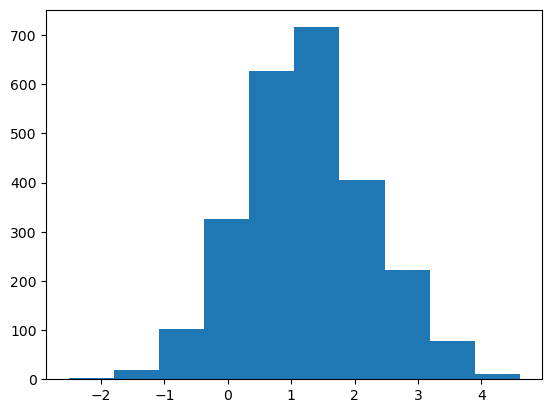

In [17]:
logERS = np.log(probDF.Engagement_Rates)
plt.hist(logERS)

In [18]:
mean, std = norm.fit(logERS)
likelihood = norm(loc = mean, scale = std).cdf(0.15)
likelihood = likelihood * 100
print(likelihood)

13.959696411169276


## 2) Does the day of the week and time of posting affect engagement rates?

## 3) How are our game titles doing in terms of social performance? Is there a specific game we should focus more or less on?

## 4) What media type performs the best?

## 5) What is our best performing campaign?

## 6) Define a posting strategy for our social channels based on your discoveries.

## 7) What suggestions would you give to the social media team if they want to expand their prescence (e.g if our CSGO youtube channel is doing well, should we expand to TikTok)?